In [33]:
library(rvest)
library(tidyverse)
library(ggrepel)

# Gathering Player data

In [3]:
rushing_player <- data.frame()

for (i in 2014:2018){
    url <- paste0('https://www.pro-football-reference.com/years/', i, '/rushing.htm')
    page <- read_html(url)
    rank_data <- html_nodes(page, '#rushing')
    dat <- as.data.frame(html_table(rank_data))
    colnames(dat) <- dat[1,]
    dat <- dat[-1,]
    dat %>% filter(Tm != 'Tm') -> dat
    dat$year <- i
    dat$Player <- gsub('\\*?\\+?', '', dat$Player)
    
    rushing_player <- rbind(rushing_player, dat)
}

write.csv(rushing_player, file = 'Data/rushing_player.csv', row.names = F)

rushing_player <- read.csv(file  = 'Data/rushing_player.csv')
head(rushing_player)

Rk,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,Lng,Y.A,Y.G,Fmb,year
1,DeMarco Murray,DAL,26,RB,16,16,392,1845,13,51,4.7,115.3,6,2014
2,LeSean McCoy,PHI,26,RB,16,16,312,1319,5,53,4.2,82.4,4,2014
3,Le'Veon Bell,PIT,22,RB,16,16,290,1361,8,81,4.7,85.1,0,2014
4,Marshawn Lynch,SEA,28,RB,16,14,280,1306,13,79,4.7,81.6,4,2014
5,Matt Forte,CHI,29,RB,16,16,266,1038,6,32,3.9,64.9,2,2014
6,Alfred Morris,WAS,26,RB,16,16,265,1074,8,30,4.1,67.1,2,2014


Now we want to make sure we are only looking at the leading rushers for each team in a given year.

In [4]:
rushing_player %>%
    group_by(Tm, year) %>%
    top_n(n = 1, wt = as.numeric(Yds)) -> top_rushers

In [5]:
summary(top_rushers)

       Rk                       Player          Tm           Age       
 Min.   :  1.00   Frank Gore       :  5   2TM    :  5   Min.   :21.00  
 1st Qu.:  9.00   Lamar Miller     :  5   ARI    :  5   1st Qu.:23.00  
 Median : 17.00   Carlos Hyde      :  4   ATL    :  5   Median :25.00  
 Mean   : 20.77   Isaiah Crowell   :  4   BAL    :  5   Mean   :25.45  
 3rd Qu.: 27.00   LeGarrette Blount:  4   BUF    :  5   3rd Qu.:27.25  
 Max.   :165.00   LeSean McCoy     :  4   CAR    :  5   Max.   :35.00  
                  (Other)          :142   (Other):138                  
      Pos            G               GS             Att             Yds        
 RB     :132   Min.   : 7.00   Min.   : 0.00   Min.   : 10.0   Min.   :  19.0  
 rb     : 22   1st Qu.:13.00   1st Qu.: 8.00   1st Qu.:160.0   1st Qu.: 643.2  
        :  8   Median :15.00   Median :12.00   Median :198.0   Median : 856.5  
 QB     :  3   Mean   :14.32   Mean   :11.36   Mean   :199.8   Mean   : 858.5  
 rb/wr  :  2   3rd Qu.:1

# Gathering Team data

In [6]:
rushing_team <- data.frame()

for (i in 2014:2018) {
    url <- paste0('https://www.pro-football-reference.com/years/', i, '/')

    url %>% read_html() %>%               # parse html
    html_nodes('#all_rushing') %>%        # select node with comment
    html_nodes(xpath = 'comment()') %>%   # select comments within node
    html_text() %>%                       # return contents as text
    read_html() %>%                       # parse text as html
    html_node('table') %>%                # select table node
    html_table() -> dat
    dat <- dat[-seq(nrow(dat)-2,nrow(dat)),]
    dat$year <- i
    
    rushing_team <- rbind(rushing_team, dat)
  }  
write.csv(rushing_team, file = 'Data/rushing_team.csv', row.names = F)
rushing_team <- read.csv(file = 'Data/rushing_team.csv')
head(rushing_team)

Rk,Tm,G,Att,Yds,TD,Lng,Y.A,Y.G,Fmb,EXP,year
1,Seattle Seahawks,16,525,2762,20,79,5.3,172.6,23,65.66,2014
2,Dallas Cowboys,16,508,2354,16,65,4.6,147.1,21,-17.90,2014
3,New York Jets,16,507,2280,11,71,4.5,142.5,25,-19.76,2014
4,San Francisco 49ers,16,470,2176,10,90,4.6,136.0,18,-32.96,2014
5,Houston Texans,16,551,2161,12,51,3.9,135.1,19,-44.90,2014
6,Cincinnati Bengals,16,492,2147,19,89,4.4,134.2,20,3.67,2014


# Pull in reference to move from team names to abbreviations

In [7]:
ref <- read.csv('C:\\Users\\osnwh2\\PyProjects\\TeamAbbrev.csv', stringsAsFactors = F)[,-1]
colnames(ref) <- c('Team', 'Tm', 'Conference', 'Division')
head(ref)

Team,Tm,Conference,Division
Arizona Cardinals,ARI,NFC,West
Atlanta Falcons,ATL,NFC,South
Baltimore Ravens,BAL,AFC,North
Buffalo Bills,BUF,AFC,East
Carolina Panthers,CAR,NFC,South
Chicago Bears,CHI,NFC,North


In [8]:
ref[nrow(ref) + 1,] <- list('Los Angeles Rams', 'LAR', 'NFC', 'West')
ref[nrow(ref) + 1,] <- list('Los Angeles Chargers', 'LAC', 'AFC', 'West')

In [9]:
nrow(ref)

[1] 34

# Need team win data.  Also pull PF and PA

In [10]:
wins <- data.frame()
for (conf in c('#AFC', '#NFC')){
for (i in 2014:2018) {
    url <- paste0('https://www.pro-football-reference.com/years/', i, '/')
    
    url %>% 
    read_html() %>%
    html_nodes(conf) %>%
    html_table() %>%
    as.data.frame() %>%
    filter(!str_detect(Tm, 'AFC|NFC')) %>%
    select(Tm, W, L, PF, PA) -> dat
    dat$year <- i
    dat$Tm <- gsub('\\*?\\+?', '', dat$Tm)
    wins <- rbind(wins, dat)
}}
wins
write.csv(wins, 'Data/wins.csv', row.names = F)
wins <- read.csv('Data/wins.csv')

Tm,W,L,PF,PA,year
New England Patriots,12,4,468,313,2014
Buffalo Bills,9,7,343,289,2014
Miami Dolphins,8,8,388,373,2014
New York Jets,4,12,283,401,2014
Pittsburgh Steelers,11,5,436,368,2014
Cincinnati Bengals,10,5,365,344,2014
Baltimore Ravens,10,6,409,302,2014
Cleveland Browns,7,9,299,337,2014
Indianapolis Colts,11,5,458,369,2014
Houston Texans,9,7,372,307,2014


In [11]:
wins$masc <- gsub('^.*\\s', '',wins$Tm)
rushing_team$masc <- gsub('^.*\\s', '',rushing_team$Tm)
ref$masc <- gsub('^.*\\s', '', ref$Team)

In [12]:
top_rushers$Tm <- case_when(
    top_rushers$Tm == 'GNB' ~ 'GB',
    top_rushers$Tm == 'KAN' ~ 'KC',
    top_rushers$Tm == 'NWE' ~ 'NE',
    top_rushers$Tm == 'NOR' ~ 'NO',
    top_rushers$Tm == 'SDG' ~ 'SD',
    top_rushers$Tm == 'SFO' ~ 'SF',
    top_rushers$Tm == 'TAM' ~ 'TB',
    TRUE ~ as.character(top_rushers$Tm))

In [13]:
ref

Team,Tm,Conference,Division,masc
Arizona Cardinals,ARI,NFC,West,Cardinals
Atlanta Falcons,ATL,NFC,South,Falcons
Baltimore Ravens,BAL,AFC,North,Ravens
Buffalo Bills,BUF,AFC,East,Bills
Carolina Panthers,CAR,NFC,South,Panthers
Chicago Bears,CHI,NFC,North,Bears
Cincinnati Bengals,CIN,AFC,North,Bengals
Cleveland Browns,CLE,AFC,North,Browns
Dallas Cowboys,DAL,NFC,East,Cowboys
Denver Broncos,DEN,AFC,West,Broncos


In [14]:
rushing_player <- merge(ref,top_rushers, by = 'Tm')

rushing_player %>%
group_by(year) %>%
summarise(n = n())

year,n
2014,32
2015,32
2016,32
2017,32
2018,32


In [15]:
nrow(rushing_player)
rushing_player %>%
group_by(Tm) %>%
summarise(n = n())

[1] 160

Tm,n
ARI,5
ATL,5
BAL,5
BUF,5
CAR,5
CHI,5
CIN,5
CLE,5
DAL,5
DEN,5


In [16]:
ref[nrow(ref) + 1,] <- list('Los Angeles Rams', 'LAR', 'NFC', 'West')
ref[nrow(ref) + 1,] <- list('Los Angeles Chargers', 'LAC', 'AFC', 'West')

In [17]:
rushing_player %>%
select(year, Tm, Team, Player, Age, Pos, G, Att, Yds, TD, Fmb, Conference, Division, masc) -> rushing_player

In [18]:
names(rushing_player)

[1] "year"       "Tm"         "Team"       "Player"     "Age"       
 [6] "Pos"        "G"          "Att"        "Yds"        "TD"        
[11] "Fmb"        "Conference" "Division"   "masc"

In [19]:
rushing_team %>%
select(Tm, Yds, Att, TD, Fmb, year, masc) %>%
merge(rushing_player, by = c('masc', 'year')) -> rushing
head(rushing)


masc,year,Tm.x,Yds.x,Att.x,TD.x,Fmb.x,Tm.y,Team,Player,Age,Pos,G,Att.y,Yds.y,TD.y,Fmb.y,Conference,Division
49ers,2014,San Francisco 49ers,2176,470,10,18,SF,San Francisco 49ers,Frank Gore,31,RB,16,255,1106,4,2,NFC,West
49ers,2015,San Francisco 49ers,1544,390,7,21,SF,San Francisco 49ers,Carlos Hyde,25,rb,7,115,470,3,1,NFC,West
49ers,2016,San Francisco 49ers,2019,458,15,29,SF,San Francisco 49ers,Carlos Hyde,26,RB,13,217,988,6,5,NFC,West
49ers,2017,San Francisco 49ers,1662,408,15,14,SF,San Francisco 49ers,Carlos Hyde,27,RB,16,240,938,8,2,NFC,West
49ers,2018,San Francisco 49ers,1902,423,7,31,SF,San Francisco 49ers,Matt Breida,23,RB,14,153,814,3,1,NFC,West
Bears,2014,Chicago Bears,1441,355,8,19,CHI,Chicago Bears,Matt Forte,29,RB,16,266,1038,6,2,NFC,North


In [21]:
colnames(rushing) <- c('Mascot', 'Year','Team', 'TeamYds', 'TeamAtt','TeamTD','TeamFmb','Abbv','Team.2','Player','Age','Pos','G','PlayerAtt','PlayerYds','PlayerTD','PlayerFmb','Conference','Division')
head(rushing)

Mascot,Year,Team,TeamYds,TeamAtt,TeamTD,TeamFmb,Abbv,Team.2,Player,Age,Pos,G,PlayerAtt,PlayerYds,PlayerTD,PlayerFmb,Conference,Division
49ers,2014,San Francisco 49ers,2176,470,10,18,SF,San Francisco 49ers,Frank Gore,31,RB,16,255,1106,4,2,NFC,West
49ers,2015,San Francisco 49ers,1544,390,7,21,SF,San Francisco 49ers,Carlos Hyde,25,rb,7,115,470,3,1,NFC,West
49ers,2016,San Francisco 49ers,2019,458,15,29,SF,San Francisco 49ers,Carlos Hyde,26,RB,13,217,988,6,5,NFC,West
49ers,2017,San Francisco 49ers,1662,408,15,14,SF,San Francisco 49ers,Carlos Hyde,27,RB,16,240,938,8,2,NFC,West
49ers,2018,San Francisco 49ers,1902,423,7,31,SF,San Francisco 49ers,Matt Breida,23,RB,14,153,814,3,1,NFC,West
Bears,2014,Chicago Bears,1441,355,8,19,CHI,Chicago Bears,Matt Forte,29,RB,16,266,1038,6,2,NFC,North


In [22]:
rushing %>%
select(-Team.2) -> rushing

In [24]:
rushing <- merge(rushing, wins, by.x = c('Mascot', 'Year'), by.y = c('masc', 'year'))
head(rushing)
nrow(rushing)

Mascot,Year,Team,TeamYds,TeamAtt,TeamTD,TeamFmb,Abbv,Player,Age,...,PlayerYds,PlayerTD,PlayerFmb,Conference,Division,Tm,W,L,PF,PA
49ers,2014,San Francisco 49ers,2176,470,10,18,SF,Frank Gore,31,...,1106,4,2,NFC,West,San Francisco 49ers,8,8,306,340
49ers,2015,San Francisco 49ers,1544,390,7,21,SF,Carlos Hyde,25,...,470,3,1,NFC,West,San Francisco 49ers,5,11,238,387
49ers,2016,San Francisco 49ers,2019,458,15,29,SF,Carlos Hyde,26,...,988,6,5,NFC,West,San Francisco 49ers,2,14,309,480
49ers,2017,San Francisco 49ers,1662,408,15,14,SF,Carlos Hyde,27,...,938,8,2,NFC,West,San Francisco 49ers,6,10,331,383
49ers,2018,San Francisco 49ers,1902,423,7,31,SF,Matt Breida,23,...,814,3,1,NFC,West,San Francisco 49ers,4,12,342,435
Bears,2014,Chicago Bears,1441,355,8,19,CHI,Matt Forte,29,...,1038,6,2,NFC,North,Chicago Bears,5,11,319,442


[1] 160

In [25]:
rushing %>%
mutate(PlayerYdsPerc = PlayerYds/TeamYds,
      PlayerAttPerc = PlayerAtt/TeamAtt) ->rushing

In [26]:
head(rushing)

Mascot,Year,Team,TeamYds,TeamAtt,TeamTD,TeamFmb,Abbv,Player,Age,...,PlayerFmb,Conference,Division,Tm,W,L,PF,PA,PlayerYdsPerc,PlayerAttPerc
49ers,2014,San Francisco 49ers,2176,470,10,18,SF,Frank Gore,31,...,2,NFC,West,San Francisco 49ers,8,8,306,340,0.5082721,0.5425532
49ers,2015,San Francisco 49ers,1544,390,7,21,SF,Carlos Hyde,25,...,1,NFC,West,San Francisco 49ers,5,11,238,387,0.3044041,0.2948718
49ers,2016,San Francisco 49ers,2019,458,15,29,SF,Carlos Hyde,26,...,5,NFC,West,San Francisco 49ers,2,14,309,480,0.4893512,0.4737991
49ers,2017,San Francisco 49ers,1662,408,15,14,SF,Carlos Hyde,27,...,2,NFC,West,San Francisco 49ers,6,10,331,383,0.5643803,0.5882353
49ers,2018,San Francisco 49ers,1902,423,7,31,SF,Matt Breida,23,...,1,NFC,West,San Francisco 49ers,4,12,342,435,0.4279706,0.3617021
Bears,2014,Chicago Bears,1441,355,8,19,CHI,Matt Forte,29,...,2,NFC,North,Chicago Bears,5,11,319,442,0.7203331,0.7492958


In [27]:

rushing %>%
group_by(Year) %>%
summarise(n = n())

Year,n
2014,32
2015,32
2016,32
2017,32
2018,32


In [28]:
summary(rushing)

    Mascot               Year                     Team        TeamYds    
 Length:160         Min.   :2014   Arizona Cardinals:  5   Min.   :1205  
 Class :character   1st Qu.:2015   Atlanta Falcons  :  5   1st Qu.:1563  
 Mode  :character   Median :2016   Baltimore Ravens :  5   Median :1736  
                    Mean   :2016   Buffalo Bills    :  5   Mean   :1770  
                    3rd Qu.:2017   Carolina Panthers:  5   3rd Qu.:1924  
                    Max.   :2018   Chicago Bears    :  5   Max.   :2762  
                                   (Other)          :130                 
    TeamAtt          TeamTD         TeamFmb          Abbv          
 Min.   :333.0   Min.   : 4.00   Min.   : 8.00   Length:160        
 1st Qu.:389.8   1st Qu.: 9.00   1st Qu.:17.00   Class :character  
 Median :412.5   Median :12.00   Median :20.00   Mode  :character  
 Mean   :422.0   Mean   :12.54   Mean   :20.43                     
 3rd Qu.:454.2   3rd Qu.:16.00   3rd Qu.:24.00                     


In [41]:
write.csv(rushing, 'Data/RushingCSV.csv')

In [29]:
summary(lm(W ~ TeamYds, data = rushing))


Call:
lm(formula = W ~ TeamYds, data = rushing)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.7430 -1.9355  0.0524  2.0653  5.6244 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.8806659  1.3754644   0.640    0.523    
TeamYds     0.0040037  0.0007665   5.223 5.47e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.84 on 158 degrees of freedom
Multiple R-squared:  0.1473,	Adjusted R-squared:  0.1419 
F-statistic: 27.28 on 1 and 158 DF,  p-value: 5.474e-07


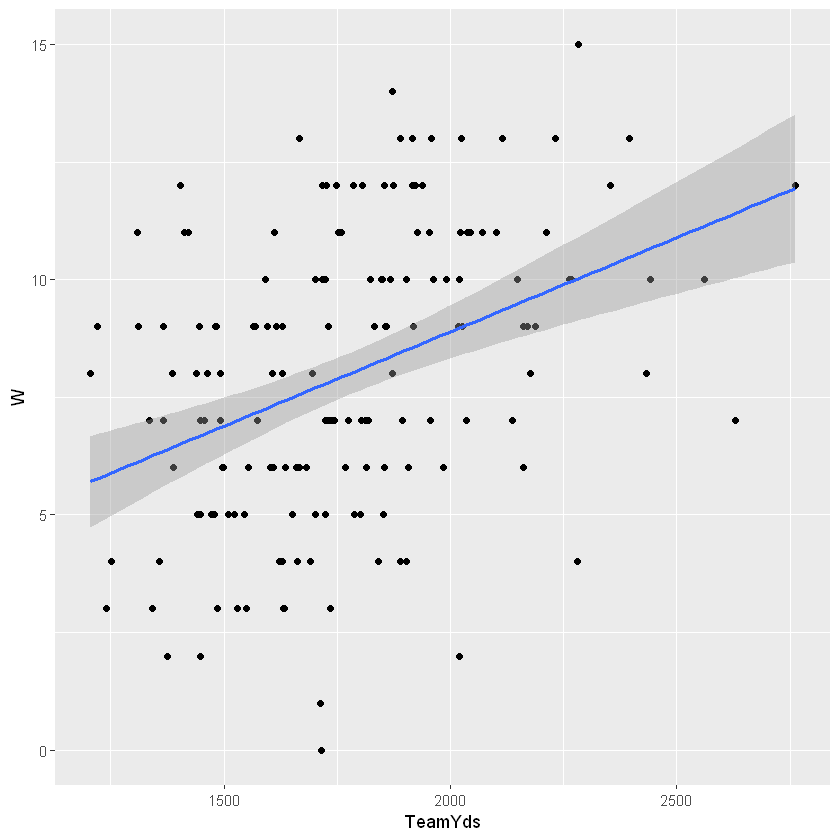

In [30]:
rushing %>%
ggplot(aes(x = TeamYds, y = W)) +
geom_point() +
geom_smooth(method = 'lm')

In [31]:
summary(lm(W~PlayerYds, data = rushing))


Call:
lm(formula = W ~ PlayerYds, data = rushing)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.8886 -1.9783 -0.0305  2.0425  6.7295 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.4929231  0.8055973   6.818 1.84e-10 ***
PlayerYds   0.0028085  0.0008739   3.214  0.00159 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.98 on 158 degrees of freedom
Multiple R-squared:  0.06136,	Adjusted R-squared:  0.05542 
F-statistic: 10.33 on 1 and 158 DF,  p-value: 0.001588


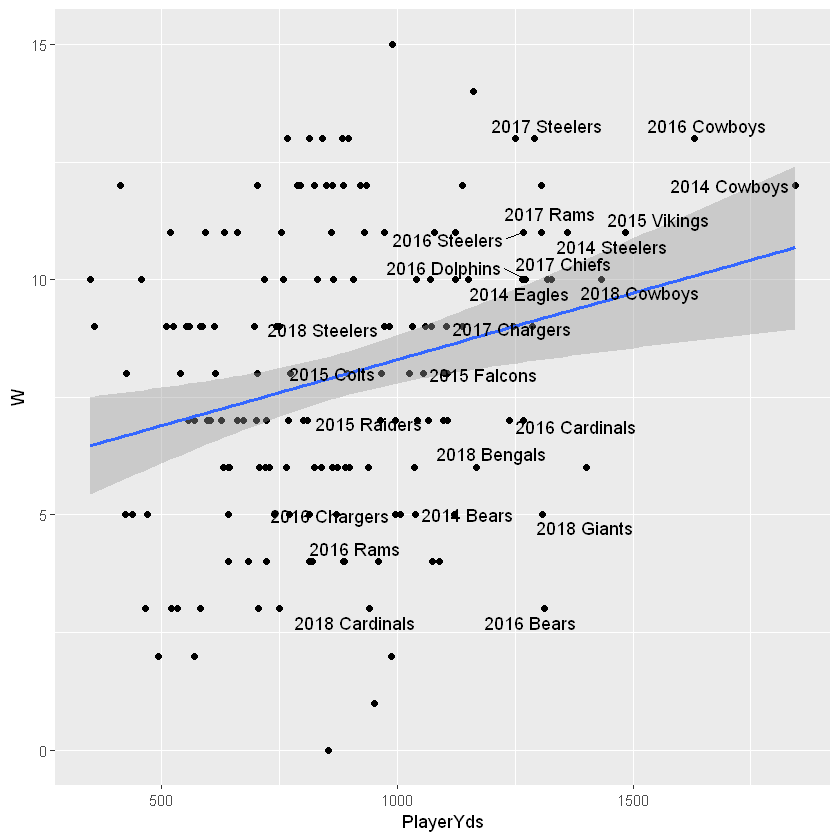

In [35]:
rushing$YearMascot <- paste(as.character(rushing$Year), rushing$Mascot)
rushing %>%
ggplot(aes(x = PlayerYds, y = W)) +
geom_point() +
geom_smooth(method = 'lm') +
geom_text_repel(data = subset(rushing, PlayerYdsPerc > .65),aes(label= YearMascot))

In [36]:
summary(lm(W ~ PlayerYdsPerc, data = rushing))


Call:
lm(formula = W ~ PlayerYdsPerc, data = rushing)

Residuals:
   Min     1Q Median     3Q    Max 
-7.969 -2.037  0.050  2.177  7.093 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     7.4827     0.9914   7.547 3.31e-12 ***
PlayerYdsPerc   0.9781     1.9342   0.506    0.614    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.073 on 158 degrees of freedom
Multiple R-squared:  0.001616,	Adjusted R-squared:  -0.004703 
F-statistic: 0.2557 on 1 and 158 DF,  p-value: 0.6138


In [37]:
names(rushing)


[1] "Mascot"        "Year"          "Team"          "TeamYds"      
 [5] "TeamAtt"       "TeamTD"        "TeamFmb"       "Abbv"         
 [9] "Player"        "Age"           "Pos"           "G"            
[13] "PlayerAtt"     "PlayerYds"     "PlayerTD"      "PlayerFmb"    
[17] "Conference"    "Division"      "Tm"            "W"            
[21] "L"             "PF"            "PA"            "PlayerYdsPerc"
[25] "PlayerAttPerc" "YearMascot"

In [38]:
rushing %>%
group_by(Year) %>%
top_n(5, PlayerYds)

Mascot,Year,Team,TeamYds,TeamAtt,TeamTD,TeamFmb,Abbv,Player,Age,...,Conference,Division,Tm,W,L,PF,PA,PlayerYdsPerc,PlayerAttPerc,YearMascot
Bears,2016,Chicago Bears,1735,380,10,26,CHI,Jordan Howard,22,...,NFC,North,Chicago Bears,3,13,279,399,0.7567723,0.6631579,2016 Bears
Bengals,2018,Cincinnati Bengals,1682,359,13,11,CIN,Joe Mixon,22,...,AFC,North,Cincinnati Bengals,6,10,368,455,0.6944114,0.6601671,2018 Bengals
Bills,2017,Buffalo Bills,2017,487,12,17,BUF,LeSean McCoy,29,...,AFC,East,Buffalo Bills,9,7,302,359,0.5642043,0.5893224,2017 Bills
Buccaneers,2015,Tampa Bay Buccaneers,2162,455,12,26,TB,Doug Martin,26,...,NFC,South,Tampa Bay Buccaneers,6,10,342,417,0.6484736,0.6329670,2015 Buccaneers
Chiefs,2017,Kansas City Chiefs,1903,405,12,14,KC,Kareem Hunt,22,...,AFC,West,Kansas City Chiefs,10,6,415,339,0.6973200,0.6716049,2017 Chiefs
Cowboys,2014,Dallas Cowboys,2354,508,16,21,DAL,DeMarco Murray,26,...,NFC,East,Dallas Cowboys,12,4,467,352,0.7837723,0.7716535,2014 Cowboys
Cowboys,2015,Dallas Cowboys,1890,408,8,18,DAL,Darren McFadden,28,...,NFC,East,Dallas Cowboys,4,12,275,374,0.5761905,0.5857843,2015 Cowboys
Cowboys,2016,Dallas Cowboys,2396,499,24,22,DAL,Ezekiel Elliott,21,...,NFC,East,Dallas Cowboys,13,3,421,306,0.6807179,0.6452906,2016 Cowboys
Cowboys,2018,Dallas Cowboys,1963,439,13,23,DAL,Ezekiel Elliott,23,...,NFC,East,Dallas Cowboys,10,6,339,324,0.7305145,0.6924829,2018 Cowboys
Dolphins,2016,Miami Dolphins,1824,406,14,26,MIA,Jay Ajayi,23,...,AFC,East,Miami Dolphins,10,6,363,380,0.6973684,0.6403941,2016 Dolphins


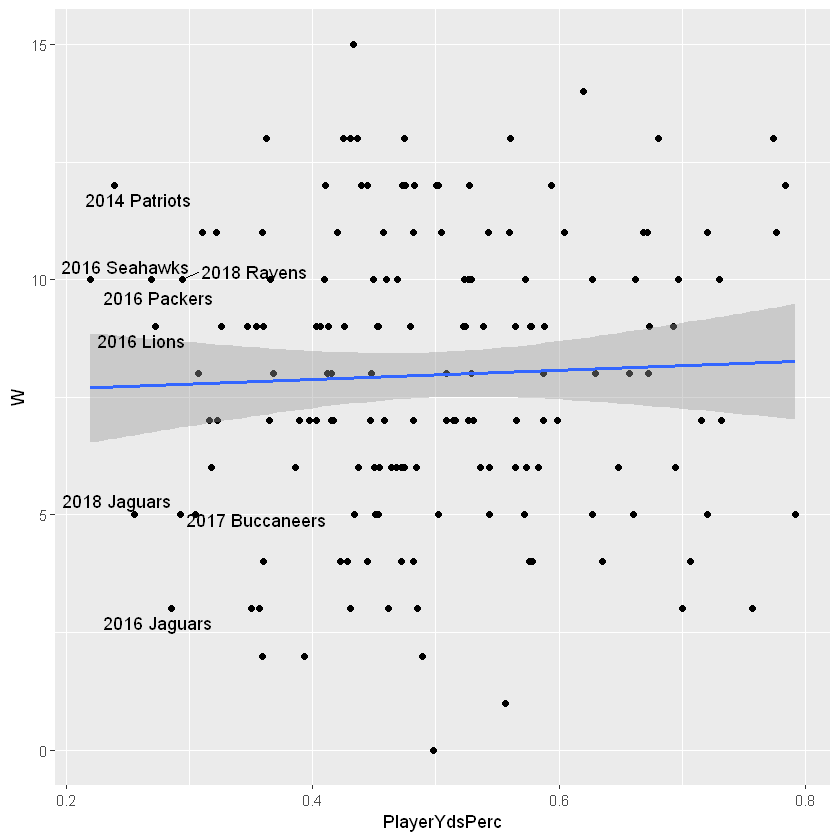

In [39]:
rushing %>%
ggplot(aes(x = PlayerYdsPerc, y = W)) +
geom_point() +
geom_smooth(method = 'lm') +
geom_text_repel(data = subset(rushing, PlayerYdsPerc < .3),aes(label= YearMascot))

In [40]:
rushing %>%
filter(Mascot == 'Seahawks' , Year == 2016)

Mascot,Year,Team,TeamYds,TeamAtt,TeamTD,TeamFmb,Abbv,Player,Age,...,Conference,Division,Tm,W,L,PF,PA,PlayerYdsPerc,PlayerAttPerc,YearMascot
Seahawks,2016,Seattle Seahawks,1591,403,13,22,SEA,Thomas Rawls,23,...,NFC,West,Seattle Seahawks,10,5,354,292,0.2193589,0.2704715,2016 Seahawks
